In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../..']

In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from src.utils import utils, evaluation_utils, visualization_utils
from sklearn.metrics import auc, precision_recall_curve
from statistics import mean
from datetime import datetime

In [3]:
# file_paths = {
#     "msl128vs30_s64_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240824/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl128vs30_s64/tl_tf_multi_sarscov2_variants_s.csv"),
#     "msl128vs30cls_s64_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240808/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl128vs30cls_s64/tl_tf_multi_sarscov2_variants_s.csv"),
#     "msl256vs30_s64_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240808/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl256vs30_s64/tl_tf_multi_sarscov2_variants_s.csv"),
#     "msl256vs30cls_s64_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240808/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl256vs30cls_s64/tl_tf_multi_sarscov2_variants_s.csv")
# }

file_paths = {
    # "msl128vs30_ae_bn_s64_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240829/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl128ae_bn_vs30_s64/tl_tf_multi_sarscov2_variants_s.csv"),
    # "msl128vs30cls_ae_bn_s64_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240829/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl128ae_bn_vs30cls_s64/tl_tf_multi_sarscov2_variants_s.csv"),
    "ProtienBert": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240902/host_multi/proteinbert/uniref90_cov_s_prot_embl_hosts/sarscov2_variants_s_prediction_results_20240902_222847.csv"),
    #"ProtienBert-2048": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240902/host_multi/proteinbert/uniref90_cov_s_prot_embl_hosts/sarscov2_variants_s_prediction_results_20240903_140317.csv"),
    #"VirProBert-msl1366": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240903/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_msl1366/tl_tf_multi_sarscov2_variants_s.csv"),
    #"Hybd-sl256s64_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240829/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl256ae_bn_vs30_s64/tl_tf_multi_sarscov2_variants_s.csv"),
    #"Hybd-sl256s64_CLS_UA": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240829/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl256ae_bn_vs30cls_s64/tl_tf_multi_sarscov2_variants_s.csv"),
    "VirProBERT": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240829/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl256ae_bn_vs30cls_s64/tl_tf_multi_sarscov2_variants_s.csv"),
    #"Hybd-sl256s64_CLS_UA_1e-5": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_variants/20240909/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-5/msl256ae_bn_vs30cls_s64/tl_tf_multi_sarscov2_variants_s.csv")
}

In [4]:
dfs = []
for k, v in file_paths.items():
    df = pd.read_csv(v)
    df["model"] = k
    if "ProtienBert" not in k:
        df["id"] = df["id"].str.extract(r"\['(.+)'\]")
    index_seq_pred = df[df["id"] == "WIV04"]["Human"].values[0]
    df["Human_pred_diff"] = df["Human"] - index_seq_pred
    dfs.append(df)
df = pd.concat(dfs)
df

,Unnamed: 0,Chicken,Human,Pig,Chinese rufous horseshoe bat,Cat,Gray wolf,Ferret,Horshoe bat,id,y_true,model_seq_len,model,Human_pred_diff
0,0.0,0.012637,0.834969,0.060891,0.018484,0.001531,0.064754,0.000847,0.005886,WIV04,Human,2048.0,ProtienBert,0.000000
1,1.0,0.012756,0.861127,0.050692,0.015803,0.001368,0.052523,0.000763,0.004968,QQM19141.1,Human,2048.0,ProtienBert,0.026157
2,2.0,0.061070,0.778867,0.071595,0.011965,0.002415,0.063974,0.002071,0.008043,QQX30509.1,Human,2048.0,ProtienBert,-0.056102
3,3.0,0.013304,0.866206,0.050010,0.015818,0.001306,0.047256,0.000887,0.005213,QRF70806.1,Human,2048.0,ProtienBert,0.031237
4,4.0,0.015970,0.834430,0.064997,0.019462,0.001207,0.055932,0.000842,0.007159,QRN78347.1,Human,2048.0,ProtienBert,-0.000539
5,5.0,0.014019,0.820124,0.067090,0.019328,0.001197,0.069696,0.000694,0.007851,QRX39425.1,Human,2048.0,ProtienBert,-0.014845
6,6.0,0.016709,0.817907,0.068888,0.018600,0.001498,0.068935,0.000964,0.006497,QRX49325.1,Human,2048.0,ProtienBert,-0.017062
7,7.0,0.012875,0.860693,0.049989,0.016454,0.001507,0.052451,0.000832,0.005198,QTJ90974.1,Human,2048.0,ProtienBert,0.025724
8,8.0,0.013844,0.842361,0.057021,0.020085,0.001358,0.058098,0.000837,0.006395,QTY83052.1,Human,2048.0,ProtienBert,0.007392
9,9.0,0.014320,0.831263,0.064963,0.018392,0.001408,0.061298,0.000867,0.007488,QUD52764.1,Human,2048.0,ProtienBert,-0.003706


In [5]:
df

,Unnamed: 0,Chicken,Human,Pig,Chinese rufous horseshoe bat,Cat,Gray wolf,Ferret,Horshoe bat,id,y_true,model_seq_len,model,Human_pred_diff
0,0.0,0.012637,0.834969,0.060891,0.018484,0.001531,0.064754,0.000847,0.005886,WIV04,Human,2048.0,ProtienBert,0.000000
1,1.0,0.012756,0.861127,0.050692,0.015803,0.001368,0.052523,0.000763,0.004968,QQM19141.1,Human,2048.0,ProtienBert,0.026157
2,2.0,0.061070,0.778867,0.071595,0.011965,0.002415,0.063974,0.002071,0.008043,QQX30509.1,Human,2048.0,ProtienBert,-0.056102
3,3.0,0.013304,0.866206,0.050010,0.015818,0.001306,0.047256,0.000887,0.005213,QRF70806.1,Human,2048.0,ProtienBert,0.031237
4,4.0,0.015970,0.834430,0.064997,0.019462,0.001207,0.055932,0.000842,0.007159,QRN78347.1,Human,2048.0,ProtienBert,-0.000539
5,5.0,0.014019,0.820124,0.067090,0.019328,0.001197,0.069696,0.000694,0.007851,QRX39425.1,Human,2048.0,ProtienBert,-0.014845
6,6.0,0.016709,0.817907,0.068888,0.018600,0.001498,0.068935,0.000964,0.006497,QRX49325.1,Human,2048.0,ProtienBert,-0.017062
7,7.0,0.012875,0.860693,0.049989,0.016454,0.001507,0.052451,0.000832,0.005198,QTJ90974.1,Human,2048.0,ProtienBert,0.025724
8,8.0,0.013844,0.842361,0.057021,0.020085,0.001358,0.058098,0.000837,0.006395,QTY83052.1,Human,2048.0,ProtienBert,0.007392
9,9.0,0.014320,0.831263,0.064963,0.018392,0.001408,0.061298,0.000867,0.007488,QUD52764.1,Human,2048.0,ProtienBert,-0.003706


In [6]:
mapping_df = pd.read_csv(os.path.join(os.getcwd(), "..","..", "..", "..", "input/data/coronaviridae/20240313/wiv04/SARS_CoV_2_Variants_ViralZone.csv"))

In [7]:
mapping_df["emergence_date"] = mapping_df["emergence_date"].apply(lambda x: datetime.strftime(datetime.strptime(x, '%b-%y'), '%m/%Y'))
mapping_df["emergence_date"] = pd.to_datetime(mapping_df["emergence_date"])

In [8]:
df = df.merge(mapping_df[["seq", "pango_lineage", "emergence_date"]], how="left", left_on="id", right_on="seq")

In [9]:
order = list(df.sort_values(by="emergence_date")["pango_lineage"].unique())
order

['WIV04',
 'B.1.1.28.1',
 'B.1.351',
 'B.1.1.7',
 'B.1.427, B.1.429',
 'B.1.1.28.2',
 'B.1.526',
 'B.1.617.2',
 'B.1.525',
 'B.1.1.1.C37',
 'B.1.617.1',
 'BA.1',
 'BA.4',
 'BA.5',
 'BQ.1.1',
 'XBB.1.5',
 'EG.5.1',
 'JN.1']

In [10]:
df[df["id"] == "WIV04"]["pango_lineage"] = "WIV04"
df[df["id"] == "WIV04"]

/tmp/ipykernel_4187840/3832981000.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df["id"] == "WIV04"]["pango_lineage"] = "WIV04"


,Unnamed: 0,Chicken,Human,Pig,Chinese rufous horseshoe bat,Cat,Gray wolf,Ferret,Horshoe bat,id,y_true,model_seq_len,model,Human_pred_diff,seq,pango_lineage,emergence_date
0,0.0,0.012637,0.834969,0.060891,0.018484,0.001531,0.064754,0.000847,0.005886,WIV04,Human,2048.0,ProtienBert,0.0,WIV04,WIV04,2019-12-01
29,NaN,0.000005,0.741561,0.023170,0.154282,0.025957,0.003929,0.018977,0.032119,WIV04,Human,NaN,VirProBERT,0.0,WIV04,WIV04,2019-12-01


In [11]:
df

,Unnamed: 0,Chicken,Human,Pig,Chinese rufous horseshoe bat,Cat,Gray wolf,Ferret,Horshoe bat,id,y_true,model_seq_len,model,Human_pred_diff,seq,pango_lineage,emergence_date
0,0.0,0.012637,0.834969,0.060891,0.018484,0.001531,0.064754,0.000847,0.005886,WIV04,Human,2048.0,ProtienBert,0.000000,WIV04,WIV04,2019-12-01
1,1.0,0.012756,0.861127,0.050692,0.015803,0.001368,0.052523,0.000763,0.004968,QQM19141.1,Human,2048.0,ProtienBert,0.026157,QQM19141.1,"B.1.427, B.1.429",2020-09-01
2,2.0,0.061070,0.778867,0.071595,0.011965,0.002415,0.063974,0.002071,0.008043,QQX30509.1,Human,2048.0,ProtienBert,-0.056102,QQX30509.1,B.1.1.28.2,2020-10-01
3,3.0,0.013304,0.866206,0.050010,0.015818,0.001306,0.047256,0.000887,0.005213,QRF70806.1,Human,2048.0,ProtienBert,0.031237,QRF70806.1,B.1.525,2020-12-01
4,4.0,0.015970,0.834430,0.064997,0.019462,0.001207,0.055932,0.000842,0.007159,QRN78347.1,Human,2048.0,ProtienBert,-0.000539,QRN78347.1,B.1.351,2020-08-01
5,5.0,0.014019,0.820124,0.067090,0.019328,0.001197,0.069696,0.000694,0.007851,QRX39425.1,Human,2048.0,ProtienBert,-0.014845,QRX39425.1,B.1.1.28.1,2020-07-01
6,6.0,0.016709,0.817907,0.068888,0.018600,0.001498,0.068935,0.000964,0.006497,QRX49325.1,Human,2048.0,ProtienBert,-0.017062,QRX49325.1,B.1.526,2020-11-01
7,7.0,0.012875,0.860693,0.049989,0.016454,0.001507,0.052451,0.000832,0.005198,QTJ90974.1,Human,2048.0,ProtienBert,0.025724,QTJ90974.1,B.1.1.1.C37,2020-12-01
8,8.0,0.013844,0.842361,0.057021,0.020085,0.001358,0.058098,0.000837,0.006395,QTY83052.1,Human,2048.0,ProtienBert,0.007392,QTY83052.1,B.1.617.1,2021-10-01
9,9.0,0.014320,0.831263,0.064963,0.018392,0.001408,0.061298,0.000867,0.007488,QUD52764.1,Human,2048.0,ProtienBert,-0.003706,QUD52764.1,B.1.617.2,2020-12-01


<Figure size 432x288 with 0 Axes>

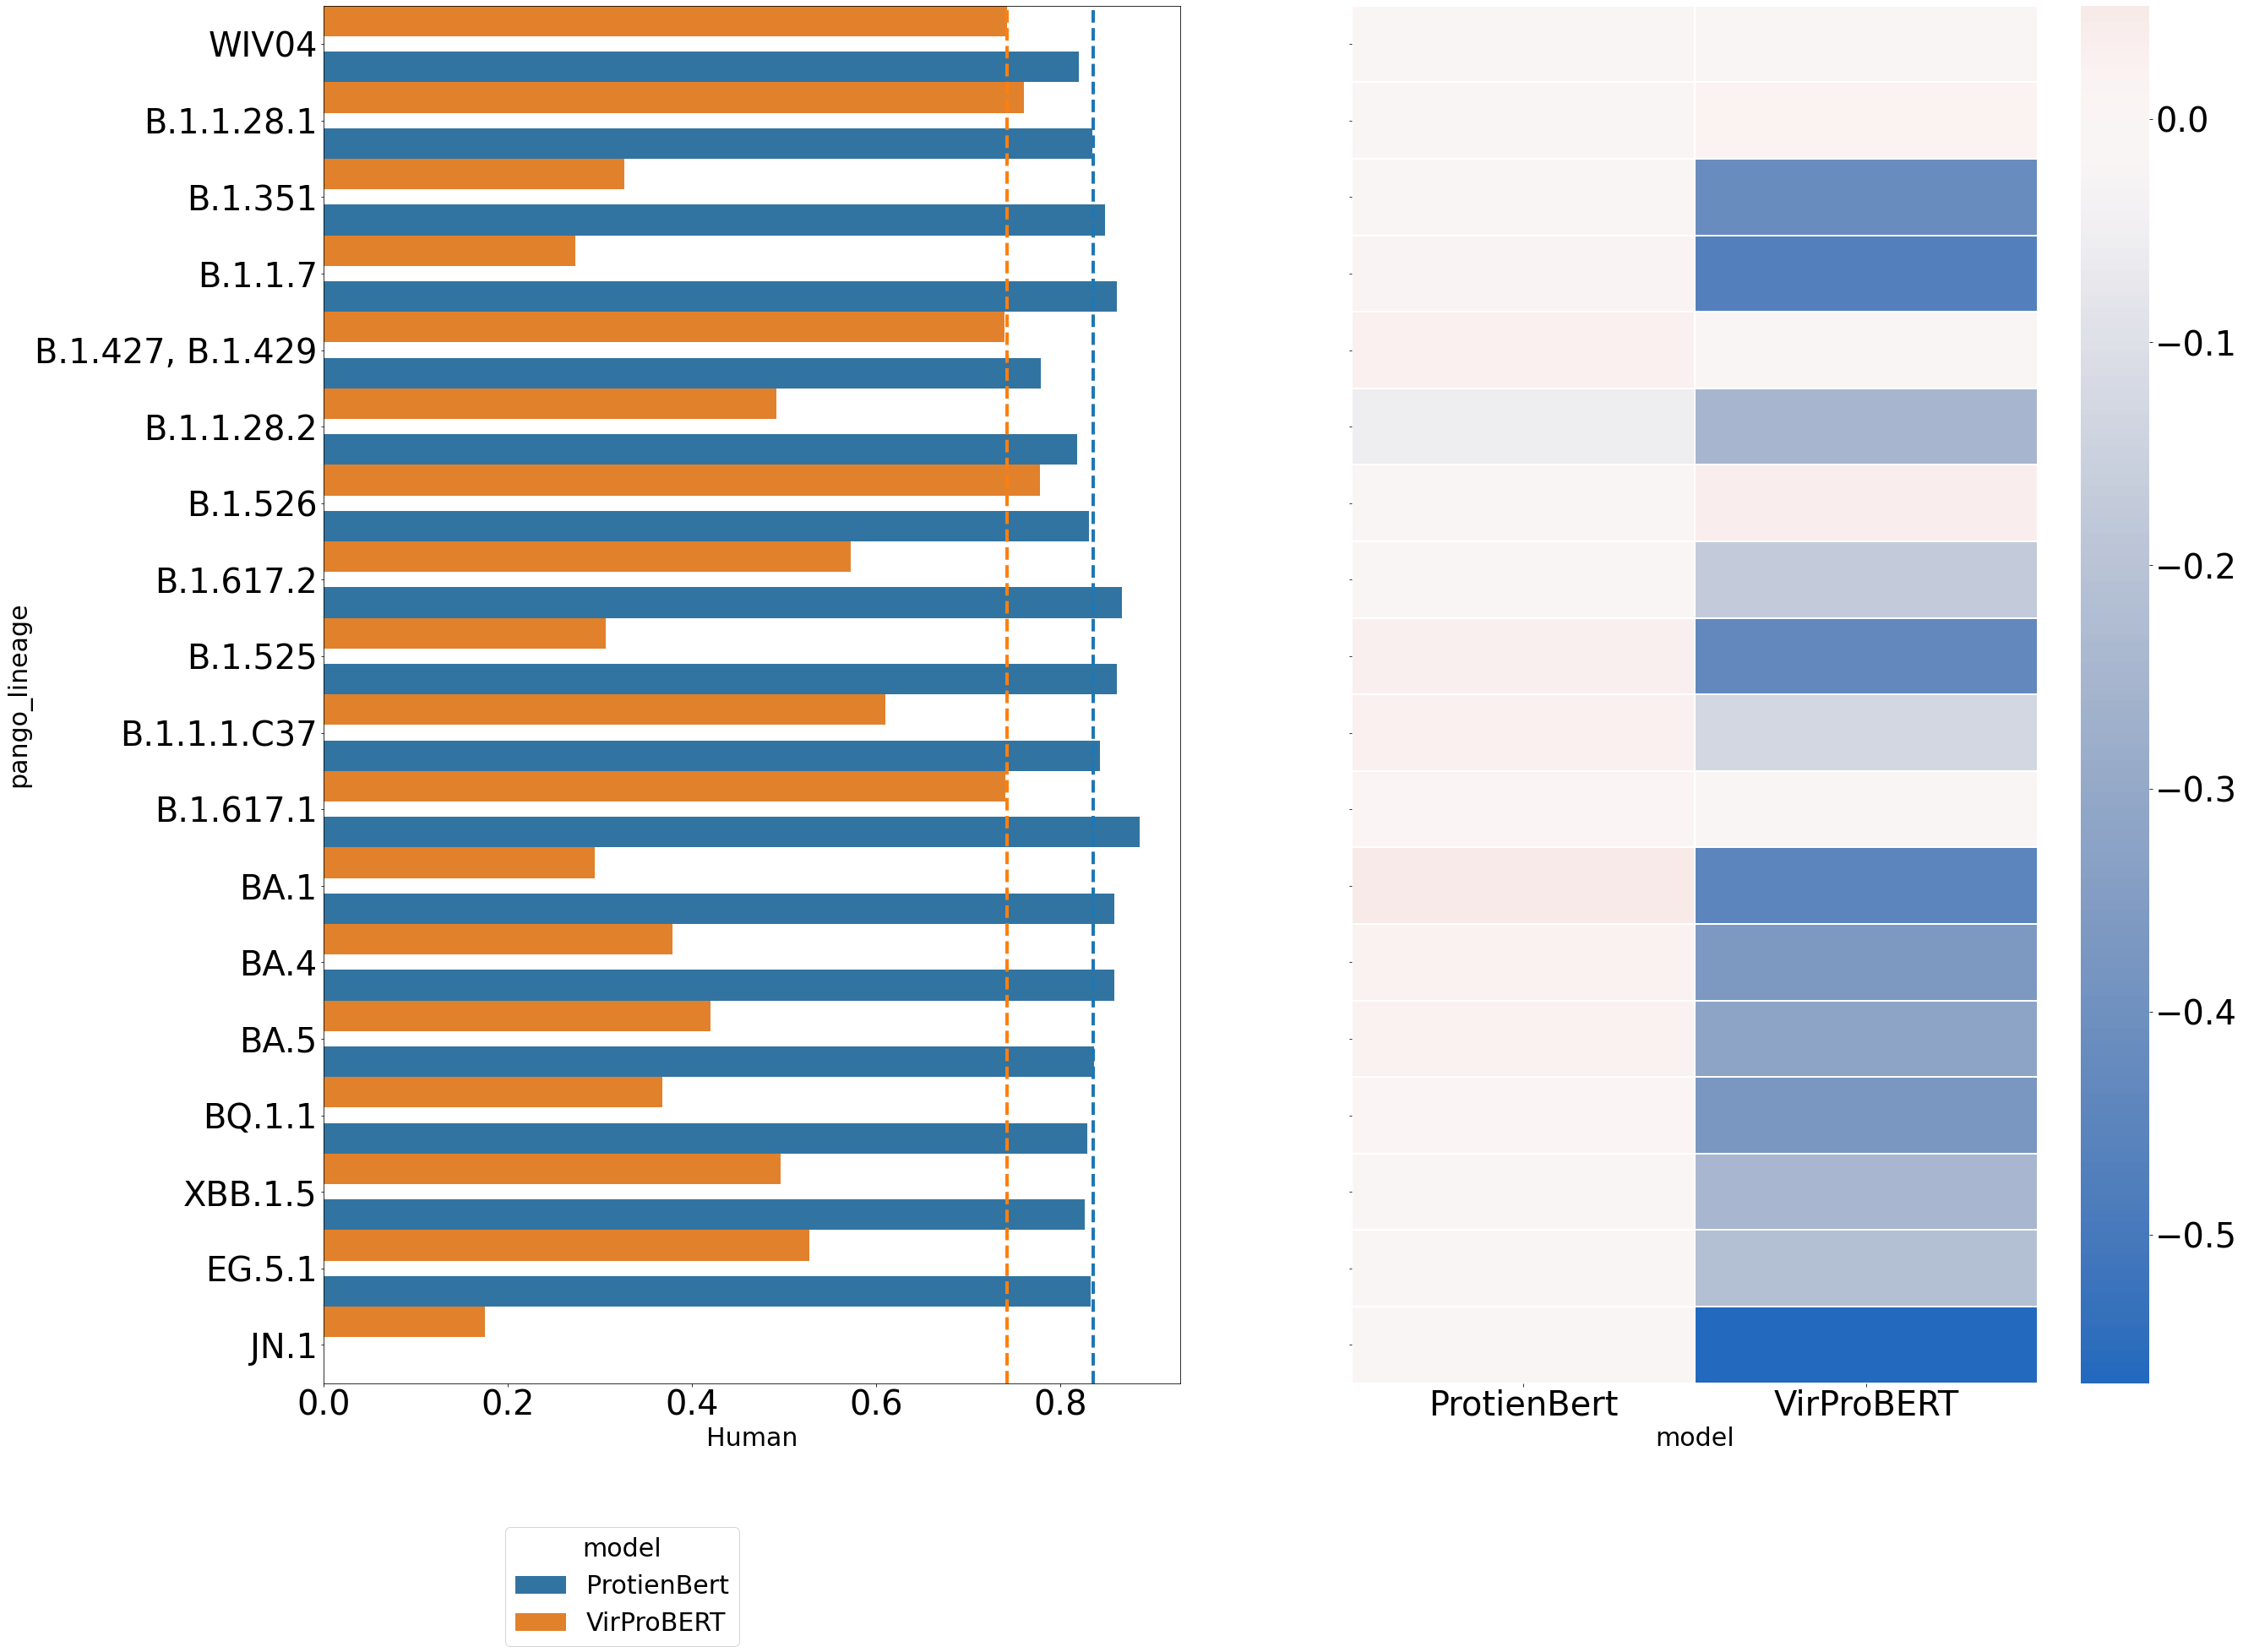

In [12]:
plt.clf()
plt.rcParams['xtick.labelsize'] = 40
plt.rcParams['ytick.labelsize'] = 40
plt.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 2, figsize=(40, 30), sharex=False, sharey=True)

colors = sns.color_palette('tab10')
models = list(df["model"].unique())

color_palette_dict = {k: v for k, v in zip(models, colors)}

sns.barplot(data=df,  x="Human", y="pango_lineage", hue="model", ax=axs[0], order=order)
               # boxprops={"facecolor": (.3, .5, .7, .5)})
sns.move_legend(axs[0], "lower right", bbox_to_anchor=(.5, -.2))

for model, color in zip(models, colors):
    axs[0].axvline(df[(df["model"] == model) & (df["id"] == "WIV04")]["Human"].values[0], color=color, linestyle="--", linewidth=4)

sns.heatmap(df.pivot(index="pango_lineage", columns="model", values="Human_pred_diff").reindex(order), ax=axs[1], linewidth=.1, center=0, cmap="vlag")
axs[1].set_ylabel("")
plt.show()

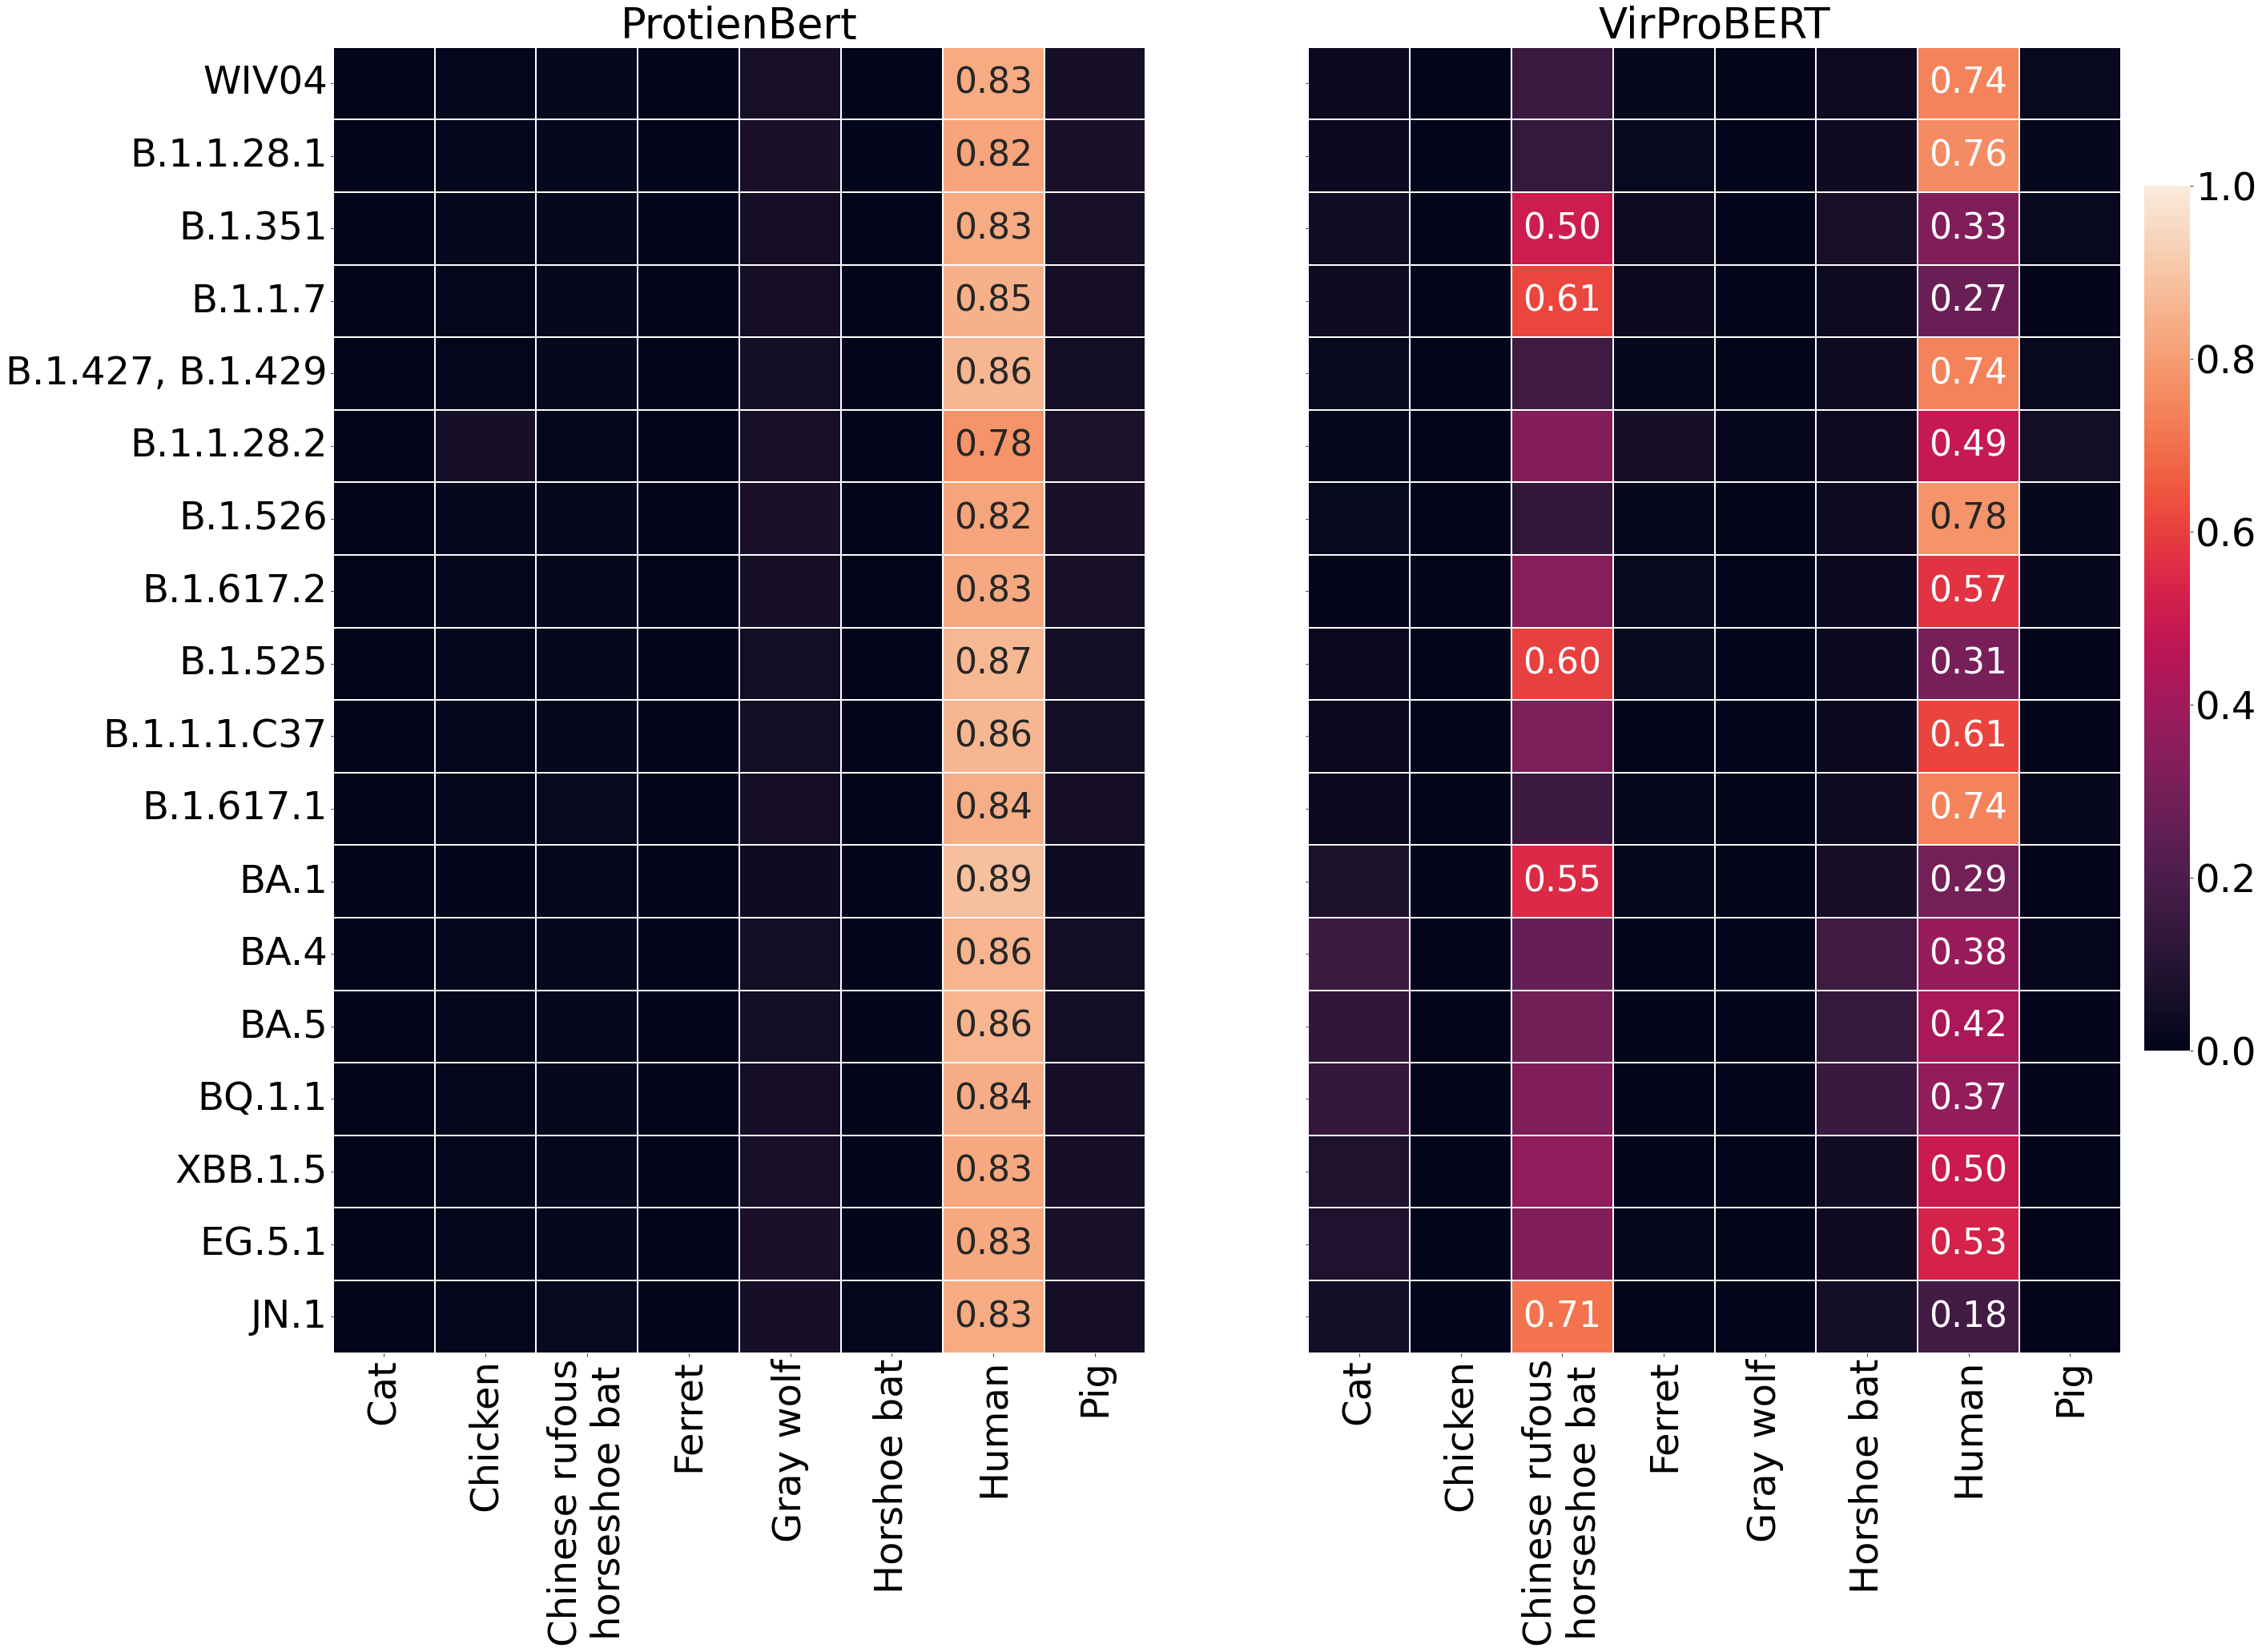

In [19]:
def get_annotation_df(heatmap_df):
    annot_df = pd.DataFrame(0, index=heatmap_df.index, columns=heatmap_df.columns)
    annot_idx = heatmap_df.idxmax(axis=1).reset_index()
    for item in annot_idx.values:
        annot_df.loc[item[0], item[1]] = "{:,.2f}".format(heatmap_df.loc[item[0], item[1]])
        annot_df.loc[item[0], "Human"] = "{:,.2f}".format(heatmap_df.loc[item[0], "Human"])

    annot_df = annot_df.astype(str)
    annot_df[annot_df == "0"] = ""
    
    return annot_df

plt.rcParams['xtick.labelsize'] = 48
plt.rcParams['ytick.labelsize'] = 48
plt.rcParams.update({'font.size': 44})
fig, axs = plt.subplots(1, 2, figsize=(40, 30), sharex=False, sharey=True)

cbar_ax = fig.add_axes([.91, .3, .02, .5])
for i, model in enumerate(models):
    heatmap_df = df[df["model"] == model][["Cat", "Chicken", "Chinese rufous horseshoe bat", "Ferret", "Gray wolf", "Horshoe bat", "Human", "Pig", "pango_lineage"]].set_index("pango_lineage").reindex(index=order)
    heatmap_df.rename(columns={"Chinese rufous horseshoe bat": "Chinese rufous\nhorseshoe bat"}, inplace=True)
    get_annotation_df(heatmap_df)
    sns.heatmap(heatmap_df, ax=axs[i], linewidth=.1, 
                annot=get_annotation_df(heatmap_df), fmt="",
                vmin=0, vmax=1,
                cbar=i == 0, 
                cbar_ax=None if i != 0 else cbar_ax)
    axs[i].set_title(model)
    axs[i].set(xlabel="", ylabel="")
    #visualization_utils.wrap_ticklabels(axs[i], axis="x", label_width=10, break_long_words=False, rotation=90)
plt.savefig(os.path.join(os.getcwd(), "..", "..", "..", "..", f"output/visualization/temp_new/sarscov2_variants_uniref90.pdf"), bbox_inches="tight")
plt.show()